In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

### Homework reflection 1

1. In Coding Quiz 1, you are asked to find the distance of the farthest match in a set. Is this farthest matching distance too far to be a meaningful match? How can you decide this?

In [2]:
hw12 = pd.read_csv('homework_1.2.csv', index_col=0)
X0 = hw12[hw12['X'] == 0].reset_index(drop=True)
X1 = hw12[hw12['X'] == 1].reset_index(drop=True)

# Matching Z values with X=1 with Z values with X=0

neigh = NearestNeighbors(n_neighbors=1).fit(X0[['Z']])
distances, indices = neigh.kneighbors(X1[['Z']])

matches = X1.copy()
matches['Matched_Index_in_X0'] = indices.flatten()
matches['Matched_Z_in_X0'] = X0.loc[indices.flatten(), 'Z'].values
matches['Y_in_X0'] = X0.loc[indices.flatten(), 'Y'].values
matches['Distance'] = distances.flatten()

# Farthest distance 
max(matches['Distance'])

0.2102170871093757

In [3]:
# Using Z-score to estimate significance of farthest match distance
max = matches.Distance.max()
mean = matches.Distance.mean()
std = matches.Distance.std()
z_score = (max - mean) / std
z_score

np.float64(2.3458567940931934)

In [4]:
# Using percentile to estimate significance of farthest match distance
percentile = np.percentile(matches['Distance'], 95)
percentile

np.float64(0.19849876912855724)

<font color='seagreen'> The farthest distance found in Code Quiz 1 was around 0.210. This distance may be considered to be <b>too far to be a meaningful match</b>. This was determined with two methods: Z-score and comparison with a percentile distance. First of all, the Z-score found was around 2.346. This means that the farthest match is about 2 standard deviations above the mean distance, which can be considered to be too far. Additionally, comparing this farthest match distance to the 95th percentile of distances, which is 0.198, it is larger than this number. This means that the farthest match distance is larger than the majority of the distances in this dataset, again making it too far to be a meaningful match.

2. In Code Quiz 1, there are two approaches to matching:\
    (A) Picking the best match X = 0 corresponding to each X = 1 using Z values.\
    (B) Using radius_neighbors to pick all matches X = 0 within a distance of 0.2 of each X = 1.

    Invent your own type of matching similar to 1 and 2 (or look one up on the internet), which has a different way to pick the matches in X = 0. Clearly explain the approach you invented or found.

In [5]:
# Using mutual nearest neighbors to find matches

# Computing full distance matrix
Z_0 = X0[['Z']].values
Z_1 = X1[['Z']].values
dist_matrix = np.abs(Z_1 - Z_0.T)

from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(Z_1, Z_0)

In [6]:
# Finding mutual nearest neighbors
X0_to_X1 = np.argmin(dist_matrix, axis=1)
X1_to_X0 = np.argmin(dist_matrix, axis=0)

X0_to_X1, X1_to_X0

(array([48, 25, 18,  9,  9, 13,  9,  9,  9,  9,  9,  9, 27,  9, 25,  9,  9,
         5, 17, 17,  9, 21, 46, 48, 47, 39, 46,  5, 18,  9, 29, 11, 24, 13,
         9,  9,  9,  9,  1, 38, 37, 13, 21,  9, 20, 37, 45,  9]),
 array([17, 38, 17, 41, 17, 17, 39, 39, 39, 13, 39, 31, 17, 41, 45, 12, 39,
        18,  2, 39, 44, 44, 32, 39, 32,  1, 45, 12, 45, 30, 39,  1, 39, 39,
        12,  0, 39, 45, 39, 25, 39, 17, 45, 17, 39, 27, 25, 24,  0, 32, 39,
        39]))

In [7]:
mutual_pairs = []
for i, j in enumerate(X0_to_X1):
    if X1_to_X0[j] == i:
        mutual_pairs.append((i, j))

In [8]:
# Applying threshold
threshold = 0.2
final_pairs = [(i, j, dist_matrix[i, j]) for (i, j) in mutual_pairs if dist_matrix[i, j] <= threshold]
final_pairs

[(0, np.int64(48), np.float64(0.0011378377461460643)),
 (1, np.int64(25), np.float64(0.007214212398742315)),
 (2, np.int64(18), np.float64(0.0005552574633511109)),
 (12, np.int64(27), np.float64(0.0048314106033744975)),
 (13, np.int64(9), np.float64(0.0023724253366049775)),
 (17, np.int64(5), np.float64(0.0003893877747161989)),
 (18, np.int64(17), np.float64(0.0007015002011201421)),
 (24, np.int64(47), np.float64(0.0028715647495387853)),
 (25, np.int64(39), np.float64(0.002554828469792214)),
 (30, np.int64(29), np.float64(0.00233993423947651)),
 (31, np.int64(11), np.float64(0.005170336060432601)),
 (32, np.int64(24), np.float64(0.012294394414781196)),
 (38, np.int64(1), np.float64(0.0020821436734020926)),
 (39, np.int64(38), np.float64(0.0014688422589249073)),
 (41, np.int64(13), np.float64(0.0003989454758536737)),
 (44, np.int64(20), np.float64(0.0006436645180140088)),
 (45, np.int64(37), np.float64(0.006599130370791517))]

In [9]:
mutual_matches_df = pd.DataFrame([
    {
        'X1_index' : i,
        'X0_index' : j,
        'Z1' : Z_1[i, 0],
        'Z0' : Z_0[j, 0],
        'Distance' : dist_matrix[i, j]
    }
    for (i, j, dist) in final_pairs
])
mutual_matches_df

,X1_index,X0_index,Z1,Z0,Distance
0,0,48,0.715189,0.716327,0.001138
1,1,25,0.645894,0.653108,0.007214
2,2,18,0.437587,0.437032,0.000555
3,12,27,0.461479,0.466311,0.004831
4,13,9,0.780529,0.778157,0.002372
5,17,5,0.568434,0.568045,0.000389
6,18,17,0.617635,0.616934,0.000702
7,24,47,0.128926,0.131798,0.002872
8,25,39,0.315428,0.317983,0.002555
9,30,29,0.161310,0.158970,0.002340


<font color='seagreen'> This method of matching is called <b>Mutual Nearest Neighbors</b>. It's mainly used as a computational tool to perform batch correction for single-cell RNA-sequencing data (https://www.biorxiv.org/content/10.1101/2024.10.08.615307v1#:~:text=Mutual%20nearest%20neighbors%20(MNN)%20is,account%20the%202D%20spatial%20information.) This method ensures that matches are mutually closest within the dataset. It's done by computing pairwise distances between the Z values for both X = 1 and X = 0 to create a "distance matrix" (Z[X = 1] - Z[X = 0]). Then, using this distance matrix, I found each X = 1 point that is closest to X = 0 and vice versa. So, for each row (each X = 1 point), I looked across the row and pick out the closest X = 0 point (the smallest distance). This was done using argmin with axis = 0. Then, the same was done for X = 0 points to X = 1 points (the columns, using axis = 1). Then, I found pairs that were a mutual nearest neighbor if the X = 1 point picked the X = 0 point as its closest AND that same X = 0 point picked the X = 1 point as its closest. With these pairs, I applied a distance threshold of 0.2 and obtained a list of mutual matches as shown above.

### Homework reflection 2

1. Invent an example situation that would use fixed effects.

    <font color='seagreen'> An example situation that would use fixed effects is if we were to study the effect of class size on student test scores. The study would be done with multiple schools over the course of 5 years and the dataset would contain student-level data, such as test scores, class size, and demographics, the school ID, and the academic year. Since each school has unobserved characteristics that don't change much over time but do differ across schools, such as quality of school leadership, neighborhood factors, and availability of extracurricular resources, it would be difficult to control for them without using fixed effects. Thus, using a fixed effects model would allow us to focus on within-school variation over time. </font>

2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken. Explain what you had to do for this. As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples? Does it stay about the same, get smaller, or get bigger?

In [10]:
# Function to perform bootstrap simulation

def bootstrap_variance_pareto(alpha, pop_size, bootstrap_size, sample_size):
    population = np.random.pareto(alpha, pop_size)
    
    means = []
    for _ in range(bootstrap_size):
        sample = np.random.choice(population, size=sample_size, replace=True)
        means.append(np.mean(sample))
    
    return np.var(means)

alpha = 3.0
bootstrap_size = 1000
pop_size = 10000
sample_sizes = [10, 50, 100, 500, 1000]

variances = []
for size in sample_sizes:
    var = bootstrap_variance_pareto(alpha, pop_size, bootstrap_size, size)
    variances.append(var)
    print(f'Sample size: {size}, Variance: {var}')

Sample size: 10, Variance: 0.07028193724607909
Sample size: 50, Variance: 0.030967737585463326
Sample size: 100, Variance: 0.006172671785338952
Sample size: 500, Variance: 0.0011143763631858746
Sample size: 1000, Variance: 0.0006505246982392121


<font color='seagreen'> For this program, I had to create a function that performs the bootstrap simulation with the Pareto distribution. This function takes a bootstrap_size and runs a for loop that obtains the means of these bootstrap samples and puts them into a list. The function then returns the variance of this list of means. Once the function was set up, another for loop was created to draw bootstrap samples (with replacement) of different sizes (10, 50, 100, 500, 1000) to seek how variance changes when sample size increases. Ultimately, we see that as sample sizes increase, variance <b>decreases</b>. 

### Homework reflection 3

1. In the event study in Coding Quiz 3, how would we go about testing for a change in the second derivative as well?

In [11]:
# Setting up features

hw31 = pd.read_csv('homework_3.1.csv', index_col=0)
hw31['time_centered'] = hw31['time'] - 50
post_event = []
for time in hw31['time']:
    if time >= 50:
        post_event.append(1)
    else:
        post_event.append(0)

hw31['post_event'] = post_event
hw31['interaction'] = hw31['time_centered'] * hw31['post_event']
hw31['time_sq'] = hw31['time_centered'] ** 2
hw31['time_sq_post'] = hw31['time_sq'] * hw31['post_event']

# Fitting the model
model1 = smf.ols('value1 ~ time_centered + post_event + interaction + time_sq + time_sq_post', data=hw31).fit()
model2 = smf.ols('value2 ~ time_centered + post_event + interaction + time_sq + time_sq_post', data=hw31).fit()
model3 = smf.ols('value3 ~ time_centered + post_event + interaction + time_sq + time_sq_post', data=hw31).fit()
model1.summary(), model2.summary(), model3.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 value1   R-squared:                       0.791
 Model:                            OLS   Adj. R-squared:                  0.780
 Method:                 Least Squares   F-statistic:                     71.17
 Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.97e-30
 Time:                        17:38:48   Log-Likelihood:                -135.02
 No. Observations:                 100   AIC:                             282.0
 Df Residuals:                      94   BIC:                             297.7
 Df Model:                           5                                         
 Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------

<font color='seagreen'> A change in the second derivative can be tested by adding a quadratic term time^2. This can allow us to check whether the rate of change of the slope differs after the event. Thus, another interaction term would be added as well (time^2 x after_event). Finally, we can fit this new model and find the coefficient of the new interaction term to test for a change in the second derivative.

2. Create your own scenario that illustrates differences-in-differences. Describe the story behind the data and show whether there is a nonzero treatment effect.

<font color='seagreen'> Given two neighboring states (State A and State B) that are similar in terms of economy and labor markets, neither state has a minimum wage law in year 1. However, in year 2, State A implements a $17 minimum wage but State B has no change. We want to see if the minimum wage increase in State A had an impact on average employment at fast-foot restaurants.

In [12]:
np.random.seed(42)

n = 25
rows = []

for state in ['A', 'B']:
    for year in [1, 2]:
        for i in range(n):
            if state == 'A' and year == 1:
                employment = 25 + np.random.normal(0, 1)
            elif state == 'A' and year == 2:
                employment = 23 + np.random.normal(0, 1)
            elif state == 'B' and year == 1:
                employment = 24 + np.random.normal(0, 1)
            else: 
                employment = 24 + np.random.normal(0, 1)
            rows.append({
                'state': state,
                'year': year,
                'employment': employment
            })
            
data = pd.DataFrame(rows)

data['post'] = (data['year'] == 2).astype(int)
data['treated'] = (data['state'] == 'A').astype(int)
data['did'] = data['post'] * data['treated']

model = smf.ols('employment ~ treated + post + did', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             employment   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     23.42
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           1.84e-11
Time:                        17:38:48   Log-Likelihood:                -130.48
No. Observations:                 100   AIC:                             269.0
Df Residuals:                      96   BIC:                             279.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.1061      0.182    132.373      0.000      23.745      24.468
treated        0.7304      0.258      2.836      0.006       0.219       1.242
post          -0.1766      0.258     -0.686      0.494      -0.688       0.335
did           -1.9473      0.364     -5.347      0.000      -2.670      -1.224
==============================================================================
Omnibus:                        0.931   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.628   Jarque-Bera (JB):                0.654
Skew:                          -0.195   Prob(JB):                        0.721
Kurtosis:                       3.071   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font color='seagreen'> Based on the summary table above, the coefficient for 'did' is -1.95 with a p-value of less than 0.001. This shows that the minimum wage caused ~2 fewer employees on average, which is a significant nonzero treatment effect.

### Homework reflection 4

1. The Coding Quiz gives two options for instrumental variables. For the second time (dividing the range of W into multiple ranges), explain how you did it, show your code, and discuss any issues you encountered.

In [13]:
hw_41 = pd.read_csv('homework_4.1.csv', index_col=0)
print(hw_41.W.min())
print(hw_41.W.max())
hw_41_bin = hw_41[(hw_41.W > 2.5) & (hw_41.W < 4.5)].copy()
Y_diff = hw_41_bin[hw_41_bin.Z == 1].Y.mean() - hw_41_bin[hw_41_bin.Z == 0].Y.mean()
X_diff = hw_41_bin[hw_41_bin.Z == 1].X.mean() - hw_41_bin[hw_41_bin.Z == 0].X.mean()
effect_2 = Y_diff / X_diff
print(effect_2)

-3.3034061894656137
4.783256692238601
1.7222083220048707


<font color='seagreen'> This was done by creating 'bins' for the W values. I first checked the range for W to see that the values range from -3.30 to 4.78. Then I arbitrarily chose a range 2.5 - 4.5 and created a subset of the original dataset that contained values only when W is between 2.5 and 4.5. Then, I calculated the effect using the average Y difference over average X difference. Other bins can be tested by just adjusting for the range of W values. In doing so, the effect remains around 1.5, which could have been found without using W at all, as seen in the first step of the Coding Quiz problem. During this process, I did not encounter any issues.

2. Plot the college outcome (Y) vs. the test score (X) in a small range of test scores around 80. On the plot, compare it with the Y probability predicted by logistic regression. The ground truth Y value is 0 or 1; don't just plot 0 or 1 - that will make it unreadable. Find some way to make it look better than that.

In [14]:
hw_42a = pd.read_csv('homework_4.2.a.csv', index_col=0)
hw_42b = pd.read_csv('homework_4.2.b.csv', index_col=0)


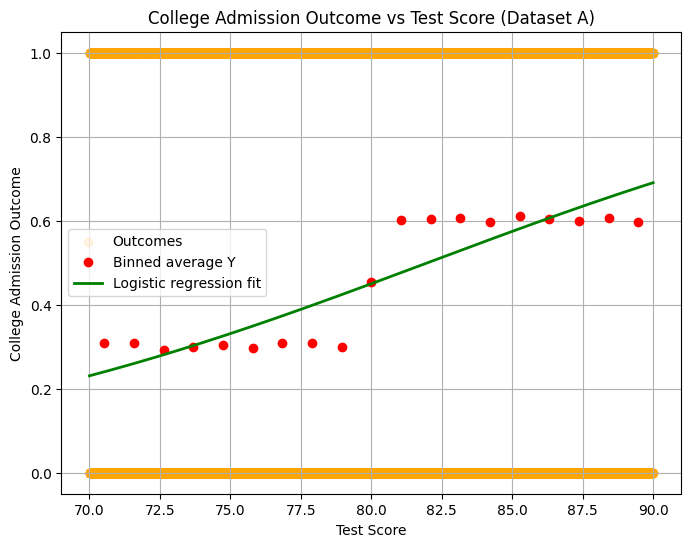

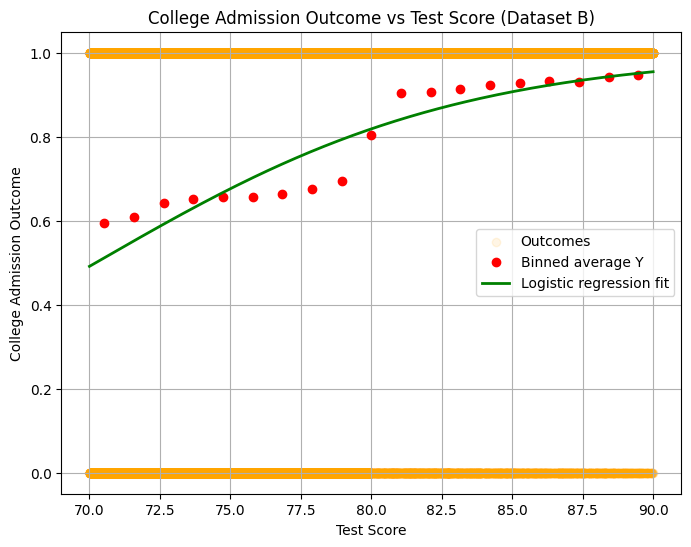

In [17]:
def plot_rdd_logistic(df, score, outcome, label):
    df_lim = df[(df[score] >= 70) & (df[score] <= 90)]
    
    X = sm.add_constant(df_lim[score])
    model = sm.Logit(df_lim[outcome], X).fit(disp=False)
    
    score_grid = np.linspace(70, 90, 200)
    X_pred = sm.add_constant(score_grid)
    y_pred = model.predict(X_pred)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(df_lim[score], df_lim[outcome], alpha=0.1, label='Outcomes', color='orange')
    
    bins = np.linspace(70, 90, 20)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_means = [df_lim[(df_lim[score] >= bins[i]) & (df_lim[score] < bins[i+1])][outcome].mean() for i in range(len(bins)-1)]
    plt.plot(bin_centers, bin_means, 'o', color='red', label='Binned average Y')
    
    plt.plot(score_grid, y_pred, label='Logistic regression fit', linewidth=2, color='green')
    
    plt.xlabel('Test Score')
    plt.ylabel('College Admission Outcome')
    plt.title(f'College Admission Outcome vs Test Score (Dataset {label})')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rdd_logistic(hw_42a, 'X', 'Y', 'A')
plot_rdd_logistic(hw_42b, 'X2', 'Y2', 'B')